In [864]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import warnings
import os
import sweetviz as sv
from IPython.display import IFrame
import time
import requests
warnings.filterwarnings('ignore')

# データ取得

In [865]:
# Binanceのインスタンスを作成（レートリミットを有効化）
exchange = ccxt.binance({
    'enableRateLimit': True,
})

# BTC/USDTのデータを取得
symbol = 'BTC/USDT'
timeframe = '1h'  # 15分足のデータ
since = exchange.parse8601('2018-01-01T00:00:00Z')  # データの開始日

# データを取得する関数（例外処理と進行状況の追加）
def fetch_all_ohlcv(symbol, timeframe, since):
    all_ohlcv = []
    now = exchange.milliseconds()
    while since < now:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=1000)
            if not ohlcv:
                break
            since = ohlcv[-1][0] + 1  # タイムスタンプを更新
            all_ohlcv.extend(ohlcv)
        except Exception as e:
            print(f'An error occurred: {e}')
            # リトライのために一時停止
            time.sleep(5)
            continue
    return all_ohlcv

# データを取得
ohlcv = fetch_all_ohlcv(symbol, timeframe, since)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# タイムスタンプを変換
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# CSVファイルとして保存
data.to_csv('btc_usdt_1h_2018_to_now.csv', index=False)

print('Data fetching and saving completed.')

Data fetching and saving completed.


In [866]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv('btc_usdt_1h_2018_to_now.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [867]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

In [868]:
# Sweetvizのレポート作成
report = sv.analyze(df)
# レポートを表示（HTMLファイルとして出力し、JupyterLabで表示）
report.show_html('sweetviz_report.html')
# JupyterLab上でSweetvizレポートをセル内に表示
IFrame(src='sweetviz_report.html', width=1000, height=600)

Done! Use 'show' commands to display/save.   |████████████████████████████████| [100%]   00:00 -> (00:00 left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [869]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_5'] = df['close'].rolling(window=5).mean()
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_75'] = df['close'].rolling(window=75).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean() #ewmはEMAを計算するためのpandasメソッド
df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean() #adjustは新しいデータに強く重みづけ
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
df['EMA_75'] = df['close'].ewm(span=75, adjust=False).mean()
df['EMA_100'] = df['close'].ewm(span=100, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

#ATR（平均真の範囲、Average True Range）
df['TR'] = df['high'] - df['low']
df['ATR_14'] = df['TR'].rolling(window=14).mean()

#ADX（平均方向性指数、Average Directional Index）
def compute_ADX(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr = high.combine(low, max) - low.combine(close.shift(), min)

    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/period).mean() / atr))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    
    return adx

df['ADX_14'] = compute_ADX(df)

#CCI（商品チャンネル指数、Commodity Channel Index）
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['CCI_14'] = (df['TP'] - df['TP'].rolling(window=14).mean()) / (0.015 * df['TP'].rolling(window=14).std())

#OBV（オンバランスボリューム、On-Balance Volume）
df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

#Stochastic Oscillator（ストキャスティクス）
df['L14'] = df['low'].rolling(window=14).min()
df['H14'] = df['high'].rolling(window=14).max()
df['%K'] = 100 * (df['close'] - df['L14']) / (df['H14'] - df['L14'])
df['%D'] = df['%K'].rolling(window=3).mean()



既存のブラウザ セッションで開いています。


In [870]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [871]:
# 欠損値の削除
df.dropna(inplace=True)

In [872]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_75', 'SMA_100', 'SMA_200',
            'EMA_5', 'EMA_10', 'EMA_20', 'EMA_30', 'EMA_50', 'EMA_75', 'EMA_100', 'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'ATR_14', 'ADX_14', 'CCI_14', 'OBV', '%K', '%D', 'hour', 'day_of_week'] + [f'lag_{lag}' for lag in range(1,6)]

X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [873]:
# データの分割（時間ベースでの分割）
split_date = '2024-09-30'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [874]:
# LightGBM用のデータセットを作成
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# パラメータの設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations' : 10000,
    'verbosity': -1,
}

# モデルの訓練
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train, lgb_eval],
                num_boost_round=1000,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)

Starting training...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.671857	valid_1's binary_logloss: 0.687532
Making predictions...


In [875]:
# モデルの評価
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5491803278688525
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       306
           1       0.55      0.52      0.53       304

    accuracy                           0.55       610
   macro avg       0.55      0.55      0.55       610
weighted avg       0.55      0.55      0.55       610



Max Drawdown: -0.0041296236970249645
Average Drawdown: -0.0022984203557456246
Annual Return: -0.0024788078992217244
Final capital: 995.870376302975
Sharpe Ratio: -12.7438165783548


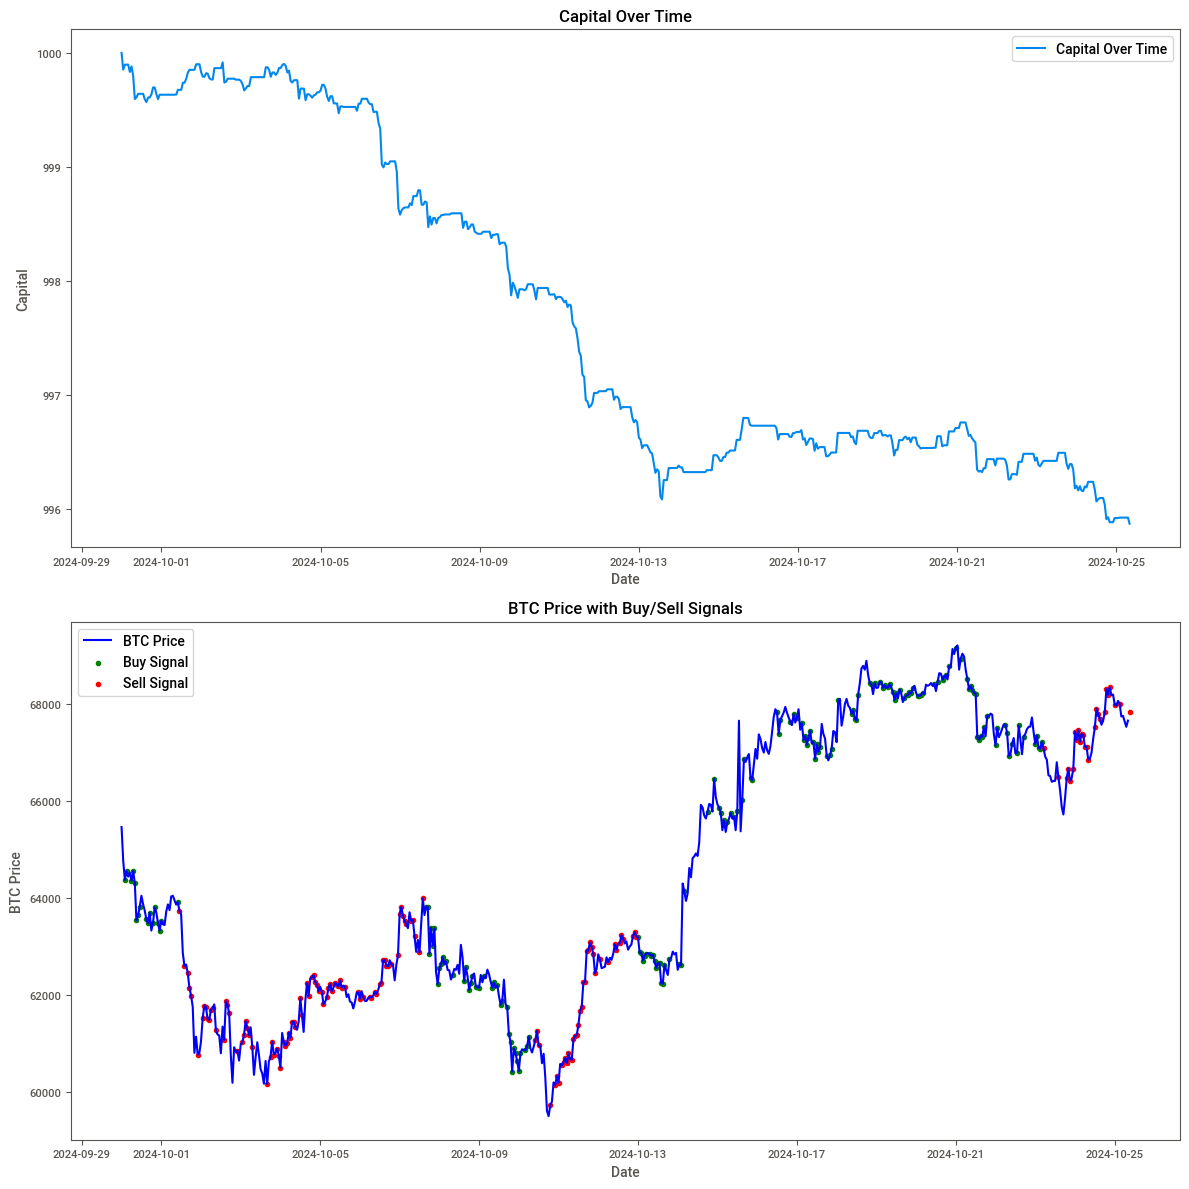

In [876]:
# 改善したバックテストコード

# 初期設定
initial_capital = 1000
capital = initial_capital
capital_history = []
positions = []
buy_signals = []
sell_signals = []

leverage = 2  # レバレッジ設定
risk_factor = 3  # リスク管理用の資本割合
fee_rate = 0.00055  # 仮の取引手数料率
slippage = 0.00005  # スリッページ率
min_confidence = 0.5  # 取引実行の確信度閾値
stop_loss_rate = 0.02  # 損失が一定値に達した場合にポジションを閉じる割合
take_profit_rate = 0.05  # 利益が一定値に達した場合にポジションを閉じる割合

# ATRの計算
atr_period = 14
df['TR'] = df['high'] - df['low']
df['ATR'] = df['TR'].rolling(window=atr_period).mean()

# 移動平均線の計算
short_ma = df['close'].rolling(window=50).mean()
long_ma = df['close'].rolling(window=200).mean()

# テスト期間の日付リスト
test_dates = X_test.index

for i in range(len(test_dates) - 1):
    date = test_dates[i]
    next_date = test_dates[i + 1]
    
    # モデルの予測と確信度
    prediction = y_pred[i]
    confidence = y_pred_prob[i]  # 確信度のリストがある前提
    
    # 価格情報の取得
    close_price = df.loc[date, 'close']
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定
    if prediction == 1 and confidence >= min_confidence and short_ma[date] > long_ma[date]:
        position = 1  # ロング
        buy_signals.append((next_date, next_close_price))
    elif prediction == 0 and confidence <= (1 - min_confidence) and short_ma[date] < long_ma[date]:
        position = -1  # ショート
        sell_signals.append((next_date, next_close_price))
    else:
        position = 0  # 中立

    # リターンの計算（取引手数料とスリッページを考慮）
    ret = ((next_close_price - close_price) / close_price * position * leverage)
    if position != 0:  # ポジションがある場合のみ取引手数料とスリッページを考慮
        ret -= (fee_rate + slippage) * leverage

    # リスク管理に基づくポジションサイズの決定（ATRを考慮）
    position_size = (capital * risk_factor) / max(df['ATR'][date], 1e-6)  # 極端に小さくならないよう最小値を設定

    # ストップロスと利益確定の適用
    if (next_close_price - close_price) / close_price < -stop_loss_rate:
        position = 0  # ストップロスによりポジションを強制終了
    elif (next_close_price - close_price) / close_price > take_profit_rate:
        position = 0  # 利益確定によりポジションを強制終了

    # 資本の更新
    capital += position_size * ret
    capital_history.append(capital)
    positions.append(position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# 最大ドローダウンの計算
roll_max = backtest_results['Capital'].cummax()
daily_drawdown = backtest_results['Capital'] / roll_max - 1.0
max_drawdown = daily_drawdown.min()
print('Max Drawdown:', max_drawdown)

# 平均ドローダウンの計算
avg_drawdown = daily_drawdown.mean()
print('Average Drawdown:', avg_drawdown)

# 年間リターンの計算
annual_return = (backtest_results['Capital'].iloc[-1] / initial_capital) ** (365.25 / len(backtest_results)) - 1
print('Annual Return:', annual_return)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)
print('Final capital:', capital)
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)  # 2行1列のグラフの1番目
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)  # 2行1列のグラフの2番目
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


In [877]:
# リターン計算やポジションサイズの確認
print("Return:", ret)
print("Position Size:", position_size)


Return: -0.006484775748797234
Position Size: 8.210417304352793


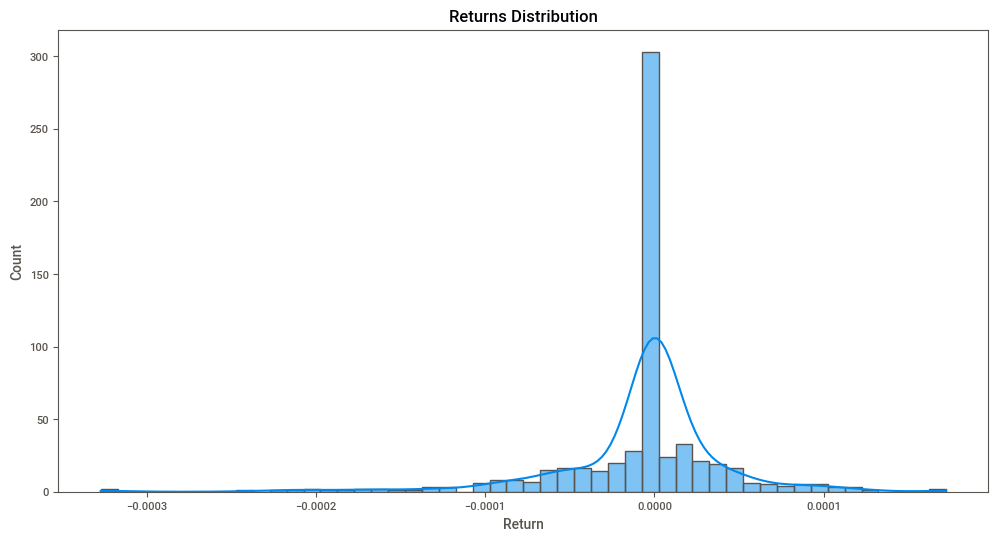

In [878]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution')
plt.show()

In [879]:
# モデルの保存
gbm.save_model('lightgbm_btc_model.txt')

In [880]:
# モデル改良のための次のステップとして、ハイパーパラメータのチューニングを行います
# グリッドサーチによるハイパーパラメータチューニング
param_grid = {
    'num_leaves': [20, 31],
    'learning_rate': [0.1, 0.05],
    'max_depth': [5, 10],
}
# モデルのインスタンス化
gbm_cv = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)
# グリッドサーチの実行
grid = GridSearchCV(gbm_cv, param_grid, cv=3)
grid.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 20}


In [881]:
# 最適なパラメータを取得
best_params = grid.best_params_
train_params = {**params, **best_params}

# モデルの訓練
print('Starting optimized training...')
gbm_optimized = lgb.train(train_params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(stopping_rounds=100)])

# 予測の実行
print('Making predictions...')
y_pred_prob = gbm_optimized.predict(X_test, num_iteration=gbm_optimized.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)


Starting optimized training...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.674517	valid_1's binary_logloss: 0.687207
Making predictions...


In [882]:
# モデルの評価
tune_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', tune_accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5475409836065573
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       306
           1       0.55      0.51      0.53       304

    accuracy                           0.55       610
   macro avg       0.55      0.55      0.55       610
weighted avg       0.55      0.55      0.55       610



Max Drawdown: -0.006761672913654815
Average Drawdown: -0.0033702484832109523
Annual Return: -0.003867202311295892
Final Capital: 993.5603398513977
Sharpe Ratio: -14.065564662125944


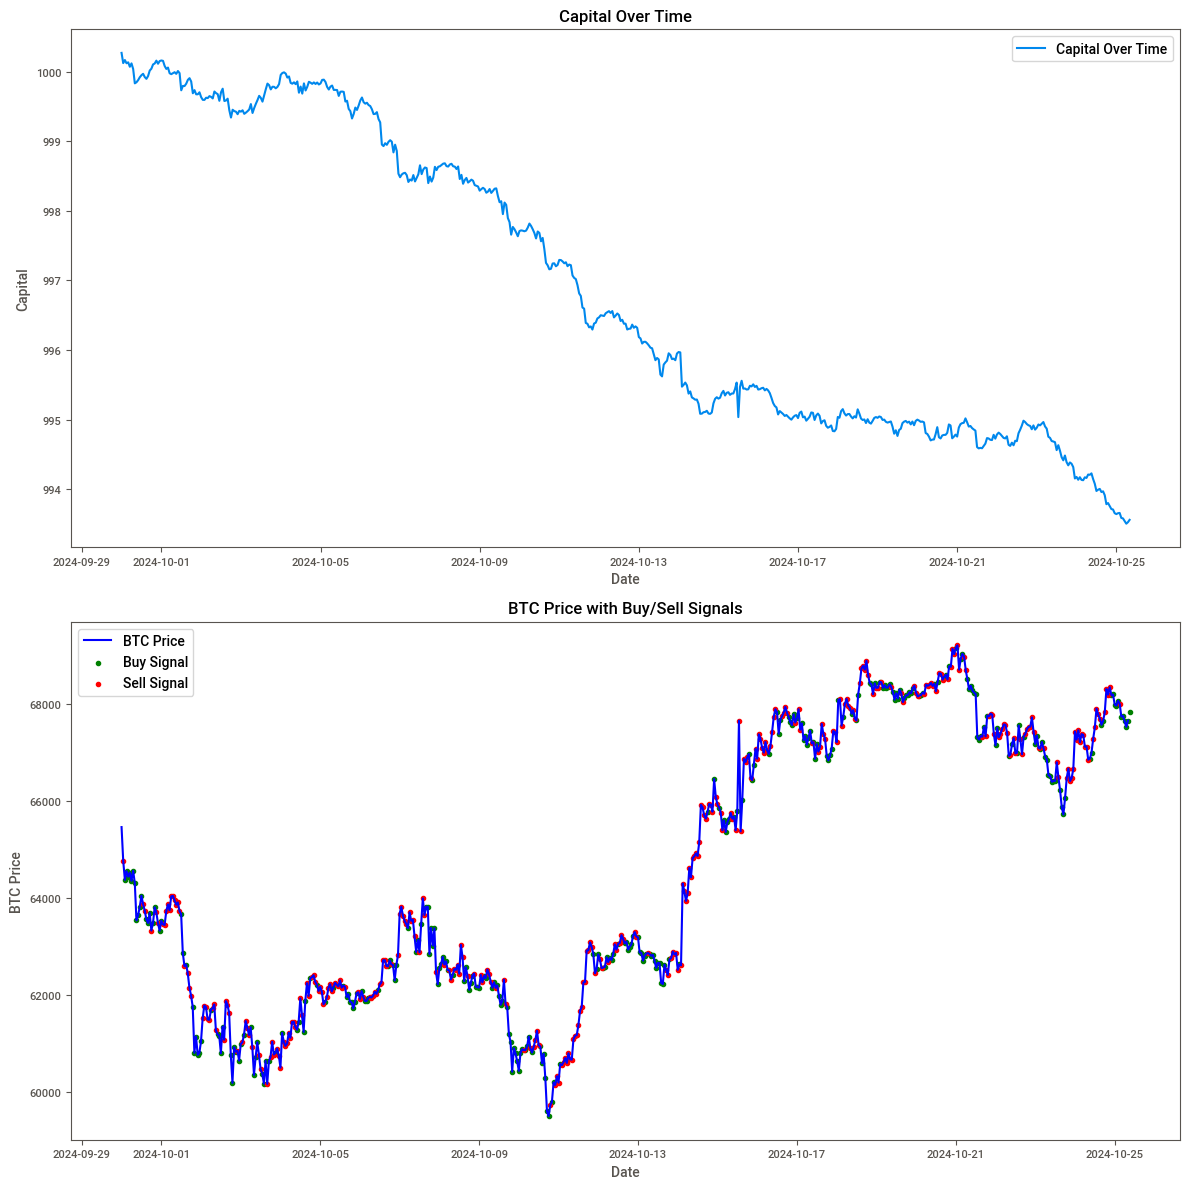

In [883]:
# 初期設定
initial_tune_capital = 1000
tune_capital = initial_tune_capital
tune_capital_history = []
tune_positions = []
tune_buy_signals = []
tune_sell_signals = []

tune_leverage = 2  # レバレッジ設定
tune_risk_factor = 3  # リスク管理用の資本割合
tune_fee_rate = 0.00055  # 仮の取引手数料率
tune_slippage = 0.00005  # スリッページ率
tune_min_confidence = 0.5  # 取引実行の確信度閾値
tune_stop_loss_rate = 0.02  # ストップロス
tune_take_profit_rate = 0.05  # 利益確定の閾値

# ATRの計算
atr_period = 14
df['TR'] = df['high'] - df['low']
df['ATR'] = df['TR'].rolling(window=atr_period).mean()

# テスト期間の日付リスト
tune_test_dates = X_test.index

for i in range(len(tune_test_dates) - 1):
    date = tune_test_dates[i]
    next_date = tune_test_dates[i + 1]
    
    # モデルの予測と確信度
    tune_prediction = y_pred[i]
    tune_confidence = y_pred_prob[i]
    
    # 価格情報の取得
    tune_close_price = df.loc[date, 'close']
    tune_next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定
    if tune_prediction == 1 and tune_confidence >= tune_min_confidence:
        tune_position = 1  # ロング
        tune_buy_signals.append((next_date, tune_next_close_price))
    elif tune_prediction == 0 and tune_confidence <= (1 - tune_min_confidence):
        tune_position = -1  # ショート
        tune_sell_signals.append((next_date, tune_next_close_price))
    else:
        tune_position = 0  # 中立

    # リターンの計算（取引手数料とスリッページを考慮）
    tune_ret = ((tune_next_close_price - tune_close_price) / tune_close_price * tune_position * tune_leverage)
    if tune_position != 0:  # ポジションがある場合のみ取引手数料とスリッページを考慮
        tune_ret -= (tune_fee_rate + tune_slippage) * tune_leverage

    # リスク管理に基づくポジションサイズ
    tune_position_size = (tune_capital * tune_risk_factor) / max(df['ATR'][date], 1e-6)  # ATRを使ったリスク管理

    # ストップロスと利益確定の適用
    if (tune_next_close_price - tune_close_price) / tune_close_price < -tune_stop_loss_rate:
        tune_position = 0  # ストップロスによるポジション終了
    elif (tune_next_close_price - tune_close_price) / tune_close_price > tune_take_profit_rate:
        tune_position = 0  # 利益確定によるポジション終了

    # 資本の更新
    tune_capital += tune_position_size * tune_ret
    tune_capital_history.append(tune_capital)
    tune_positions.append(tune_position)

# バックテスト結果のデータフレーム作成
tune_backtest_results = pd.DataFrame(index=tune_test_dates[:-1])
tune_backtest_results['tune_capital'] = tune_capital_history
tune_backtest_results['tune_position'] = tune_positions

# リターンの計算
tune_backtest_results['tune_return'] = tune_backtest_results['tune_capital'].pct_change().fillna(0)

# 最大ドローダウンの計算
tune_roll_max = tune_backtest_results['tune_capital'].cummax()
tune_daily_drawdown = tune_backtest_results['tune_capital'] / tune_roll_max - 1.0
tune_max_drawdown = tune_daily_drawdown.min()
print('Max Drawdown:', tune_max_drawdown)

# 平均ドローダウンの計算
tune_avg_drawdown = tune_daily_drawdown.mean()
print('Average Drawdown:', tune_avg_drawdown)

# 年間リターンの計算
tune_annual_return = (tune_backtest_results['tune_capital'].iloc[-1] / initial_tune_capital) ** (365.25 / len(tune_backtest_results)) - 1
print('Annual Return:', tune_annual_return)

# シャープレシオの計算（リスクフリーレートは0と仮定）
tune_sharpe_ratio = (tune_backtest_results['tune_return'].mean() / tune_backtest_results['tune_return'].std()) * np.sqrt(365 * 24)
print('Final Capital:', tune_capital)
print('Sharpe Ratio:', tune_sharpe_ratio)

# 資産推移と売買のプロット
plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)
plt.plot(tune_backtest_results.index, tune_backtest_results['tune_capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)
plt.plot(df.loc[tune_test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if tune_buy_signals:
    buy_dates, buy_prices = zip(*tune_buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if tune_sell_signals:
    sell_dates, sell_prices = zip(*tune_sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()


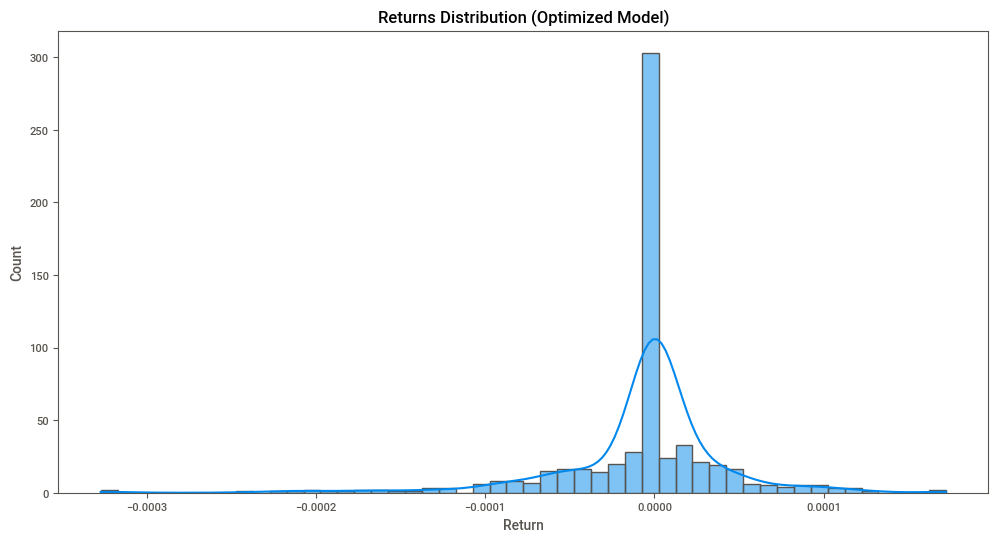

In [884]:
# リターン分布のプロット
plt.figure(figsize=(12,6))
sns.histplot(backtest_results['Return'], bins=50, kde=True)
plt.title('Returns Distribution (Optimized Model)')
plt.show()

In [885]:
# モデルの保存
gbm_optimized.save_model('lightgbm_btc_model_optimized.txt')

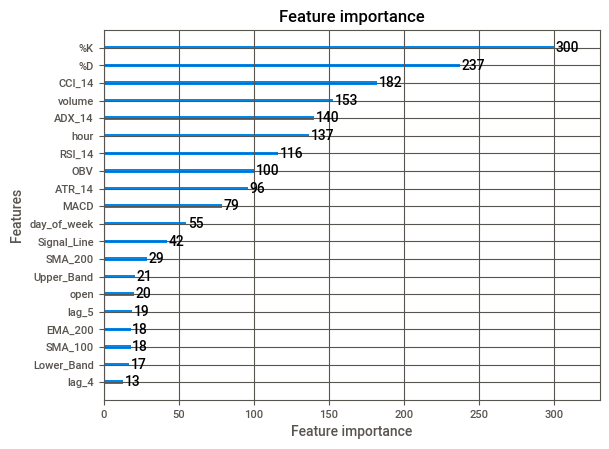

In [886]:
# 特徴量の重要度をプロット
lgb.plot_importance(gbm_optimized, max_num_features=20)
plt.show()

In [887]:
# 保存するデータ
data = {'時間足':[timeframe], 'レバレッジ':[leverage], '特徴量' : [features], 'テスト開始時期' : [split_date], '精度' : [accuracy], 
        '最終資産' : [capital], 'シャープレシオ' : [sharpe_ratio], 'チューン後精度' : [tune_accuracy], 
        'チューン後最終資産' : [tune_capital], 'チューン後シャープレシオ' : [tune_sharpe_ratio]}

df_result = pd.DataFrame(data)

# 'result.csv'が既に存在するか確認
file_exists = os.path.isfile('result.csv')

# CSVファイルに追記、ファイルが既に存在する場合はヘッダーを追加しない
df_result.to_csv('result.csv', mode='a', header=not file_exists, index=False)

In [888]:
print('Final capital:', capital)
print('Final tune_capital:', tune_capital)

Final capital: 995.870376302975
Final tune_capital: 993.5603398513977
